# Inter-channel interference (ICI) classification using *counting vectors* in a 16 GBd system. 

## Initialization

### Google Colab checking

In [1]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive

    GOOGLE_COLAB = True
    ROOT = "/content/drive/MyDrive/SOFA/ICI_Project"

    drive.mount("/content/drive")
    !cp {ROOT}"/sofa.py" "."
    !cp {ROOT}"/counting_vectors_16f.csv" "."
    !cp {ROOT}"/counting_vectors_16g.csv" "."
else:
    GOOGLE_COLAB = False
    ROOT = "."

### Libraries

In [2]:
import json
import os
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import sofa
import tensorflow as tf
import tensorflow.keras as ker
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    multilabel_confusion_matrix,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, models, regularizers, utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

2024-01-20 17:53:02.127426: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 17:53:02.187901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 17:53:02.187967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 17:53:02.191662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 17:53:02.206503: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 17:53:02.210626: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
GPU = tf.config.list_physical_devices("GPU")
if len(GPU) > 0:
    print(f"Using GPU: {GPU}")

### Globals

In [4]:
def calc_once(varname, fn, args):
    """Calculate a variable only once."""
    if varname not in globals():
        return fn(**args)
    return eval(varname)


def classificator(df, interval_lst, column_name):
    """Transforms a dataframe's column into classes"""
    array = df[column_name].to_numpy()
    indexes_lst = []
    for i, interval in enumerate(interval_lst):
        lower_limit, upper_limit = interval
        indexes_lst.append(
            np.intersect1d(
                np.where(lower_limit < array), np.where(array <= upper_limit)
            )
        )

    classfull = df[column_name]
    for index, indexes in enumerate(indexes_lst):
        classfull[indexes] = index

    df_classfull = df.clone()
    df_classfull = df_classfull.with_columns(classfull.alias(column_name))

    return df_classfull

def classifier_model(
    layers_props_lst: list, classes_n: int, loss_fn: ker.losses.Loss, input_dim: int
) -> ker.models.Sequential:
    """Compile a sequential model for classification purposes."""
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(input_dim=input_dim, **layer_props))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")

    return model


def classification_crossvalidation(
    X, y, X_prod, y_prod, n_splits, layer_props, classes_n, loss_fn, callbacks
):
    """Crossvalidation of a classification network."""
    # Scores dict
    scores = {}
    scores["model"] = []
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": [], "prod": []}
    scores["f1"] = {"train": [], "test": [], "prod": []}
    scores["cm"] = {"train": [], "test": [], "prod": []}

    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        X_prod_kf = sc.transform(X_prod)

        model = classifier_model(layer_props, classes_n, loss_fn, X_train.shape[1])

        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train,
                y_train,
                epochs=2500,
                batch_size=64,
                callbacks=callbacks,
                verbose=0,
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        loss = loss.history["loss"]

        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train, verbose=0)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf, verbose=0)
        # Predict using production values
        fuzzy_predictions_prod = model.predict(X_prod_kf, verbose=0)

        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])
        predictions_prod = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_prod])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": y_train, "Predicted ICI": predictions_train}
        )
        train_data_test = pl.DataFrame(
            {"ICI": y_test, "Predicted ICI": predictions_test}
        )
        train_data_prod = pl.DataFrame(
            {"ICI": y_prod, "Predicted ICI": predictions_prod}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        )
        acc_score_prod = accuracy_score(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            train_data_train["ICI"], train_data_train["Predicted ICI"], average="micro"
        )
        f1_score_test = f1_score(
            train_data_test["ICI"], train_data_test["Predicted ICI"], average="micro"
        )
        f1_score_prod = f1_score(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"], average="micro"
        )

        # RMSE
        cm_score_train = multilabel_confusion_matrix(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        ).tolist()
        cm_score_test = multilabel_confusion_matrix(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        ).tolist()
        cm_score_prod = multilabel_confusion_matrix(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        ).tolist()

        # Append to lists
        scores["model"].append(model)
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["acc"]["prod"].append(acc_score_prod)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["f1"]["prod"].append(f1_score_prod)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        scores["cm"]["prod"].append(cm_score_prod)

    return scores


def test_classification_model(
    data,
    data_prod,
    n_splits,
    classes_n,
    max_neurons,
    activations,
    use_osnr=True,
    loss_fn="sparse_categorical_crossentropy",
):
    """Test a spectral spacing estimation model with given parameters."""
    n_feat = data.shape[1]
    var_n = n_feat - 1 if use_osnr else n_feat - 2

    # Split variables
    # Features
    X = np.array(data[:, 0:var_n])
    X_prod = np.array(data_prod[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    y_prod = np.array(data_prod[:, -1])

    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(f"{layer_props}{' + OSNR' if use_osnr else ''} {classes_n} classes")
    callbacks = [
        EarlyStopping(
            monitor="loss", patience=30, mode="min", restore_best_weights=True
        )
    ]

    return classification_crossvalidation(
        X, y, X_prod, y_prod, n_splits, layer_props, classes_n, loss_fn, callbacks
    )

def plot_cm(scores, interval_lst):
    CM = np.array(scores.get("cm").get("test"))
    for n, interval in enumerate(interval_lst):
        result = np.zeros(CM[0][0].shape)
        for cm in CM:
            result = np.add(result, cm[n])
        result /= np.sum(result)
        disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=["Positive", "Negative"])
        disp.plot(colorbar=False)
        lower_limit, upper_limit = interval 
        plt.title(f"Confusion matrix for class from {lower_limit} GHz up to {upper_limit} GHz")
        plt.show()

## FCM

### Load data

In [5]:
if GOOGLE_COLAB:
    cv16f_file = "counting_vectors_16f.csv"
else:
    cv16f_file = "../../Databases/16fBd/counting_vectors_16f.csv"

cv16f = pl.read_csv(cv16f_file, has_header=False, dtypes=[pl.Float64])
# Show the original dataframe
cv16f

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7955,0.1557,0.0309,0.0145,0.0021,0.0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7988,0.1467,0.034,0.0149,0.0035,0.0015,0.0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.789,0.1601,0.0332,0.0132,0.0032,0.0008,0.0002,0.0002,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7957,0.1542,0.0311,0.0152,0.0024,0.0013,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7947,0.1477,0.0352,0.0143,0.0053,0.0023,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7976,0.152,0.0316,0.0152,0.0031,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7736,0.1619,0.0386,0.0179,0.0039,0.0031,0.0004,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8089,0.1469,0.0293,0.0114,0.0025,0.0009,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8025,0.1523,0.029,0.013,0.0025,0.0005,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [6]:
interval_lst = {"2": [(0, 35), (35, 50)],
                "3": [(0, 32), (32, 35), (35, 50)],
                "4": [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)],
                "5": [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]}

cv16f_class = {}
for classes_n, interval in interval_lst.items():
    cv16f_class[classes_n] = classificator(cv16f, interval, "column_18")
cv16f_class

{'2': shape: (680, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.7955   ┆ 0.1557   ┆ 0.0309   ┆ 0.0145   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.7988   ┆ 0.1467   ┆ 0.034    ┆ 0.0149   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.789    ┆ 0.1601   ┆ 0.0332   ┆ 0.0132   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.7957   ┆ 0.1542   ┆ 0.0311   ┆ 0.0152   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

In [7]:
# Shuffle the dataframe
cv16f_class_shuffled = {}
for classes_n, df in cv16f_class.items():
    cv16f_class_shuffled[classes_n] = df.sample(n=len(df), shuffle=True, seed=1036681523)
cv16f_class_shuffled

{'2': shape: (680, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 0.0       │
 │ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 0.0       │
 │ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

In [8]:
# Extract 10% of the data to use later for "production" testing
cv16f_class_prod = {}
for classes_n, df in cv16f_class_shuffled.items():
    cv16f_class_prod[classes_n] = df[: int(len(df) * 0.1)]
cv16f_class_prod

{'2': shape: (68, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 0.0       │
 │ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 0.0       │
 │ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ 

In [9]:
# Use the rest of the data for normal testing
cv16f_class_new = {}
for classes_n, df in cv16f_class_shuffled.items():
    cv16f_class_new[classes_n] = df[int(len(df) * 0.1) :]
cv16f_class_new

{'2': shape: (612, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.9999   ┆ 0.0001   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 26.3      ┆ 1.0       │
 │ 0.9975   ┆ 0.0024   ┆ 0.0      ┆ 0.0001   ┆ … ┆ 0.0       ┆ 0.0       ┆ 26.3      ┆ 0.0       │
 │ 0.9802   ┆ 0.0193   ┆ 0.0003   ┆ 0.0002   ┆ … ┆ 0.0       ┆ 0.0       ┆ 19.3      ┆ 0.0       │
 │ 0.977    ┆ 0.0214   ┆ 0.0011   ┆ 0.0005   ┆ … ┆ 0.0       ┆ 0.0       ┆ 23.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

### Hyperparameters evaluation

In [ ]:
try:
    cv16f_class_results = sofa.load_hdf5(f"{ROOT}/cv16f_class_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16f_class_results = defaultdict(
        defaultdict(defaultdict(defaultdict(defaultdict().copy).copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            for n in classes_n:
                args = {
                    "data": cv16f_class_new[n],
                    "data_prod": cv16f_class_prod[n],
                    "n_splits": 5,
                    "classes_n": int(n),
                    "max_neurons": int(neurons),
                    "activations": activations,
                    "use_osnr": True if osnr == "osnr" else False,
                }
                act_fn_name = "".join([s[0] for s in activations])
                if cv16f_class_results[act_fn_name][neurons][osnr][n] == defaultdict():
                    # Get results
                    results = test_classification_model(**args)
                    # Serialize model
                    results["model"] = [
                        utils.serialize_keras_object(model) for model in results["model"]
                    ]
                    # Save serialized model for serialization
                    cv16f_class_results[act_fn_name][neurons][osnr][n] = results
                    # Save results with serialized model
                    print("Saving results...")
                    sofa.save_hdf5(cv16f_class_results, f"{ROOT}/cv16f_class_results.h5", n_backups = 5)
                    print("Results saved!")

### Results

In [ ]:
cv16f_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_class_results, neurons, target="neurons", metric="acc", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16f_neurons_avg_results, "Maximum number of neurons", log=True)

In [ ]:
cv16f_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_class_results, layers, target="layers", metric="acc", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16f_layers_avg_results, "Number of layers", log=False, intx=True)

In [ ]:
cv16f_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_class_results, osnr, target="osnr", metric="acc", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"With OSNR  Without OSNR")
print(f"{cv16f_osnr_avg_results[0]:.3f}       {cv16f_osnr_avg_results[1]:.3f}")

In [ ]:
cv16f_classes_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_class_results, classes, target="classes", metric="acc", score="test"
        )
    )
    for classes in n_classes
]
x = n_classes
plot_results(x, cv16f_classes_avg_results, "Number of classes", log=False, intx=True)

### Sort models by score

In [ ]:
cv16f_better_models_df = get_better_models(
    cv16f_class_results, metric="acc", score="test"
)
cv16f_better_models_df.head(10)

In [28]:
try:
    cv16f_reg_results = sofa.load_hdf5(f"{ROOT}/cv16f_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16f_reg_results = defaultdict(
        defaultdict(defaultdict(defaultdict().copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {
                "data": cv16f_new,
                "data_prod": cv16f_prod,
                "n_splits": 5,
                "max_neurons": int(neurons),
                "activations": activations,
                "use_osnr": True if osnr == "osnr" else False,
            }
            act_fn_name = "".join([s[0] for s in activations])
            if cv16f_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [
                    utils.serialize_keras_object(model) for model in results["model"]
                ]
                # Save serialized model for serialization
                cv16f_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(cv16f_reg_results, f"{ROOT}/cv16f_reg_results.h5")
                print("Results saved!")

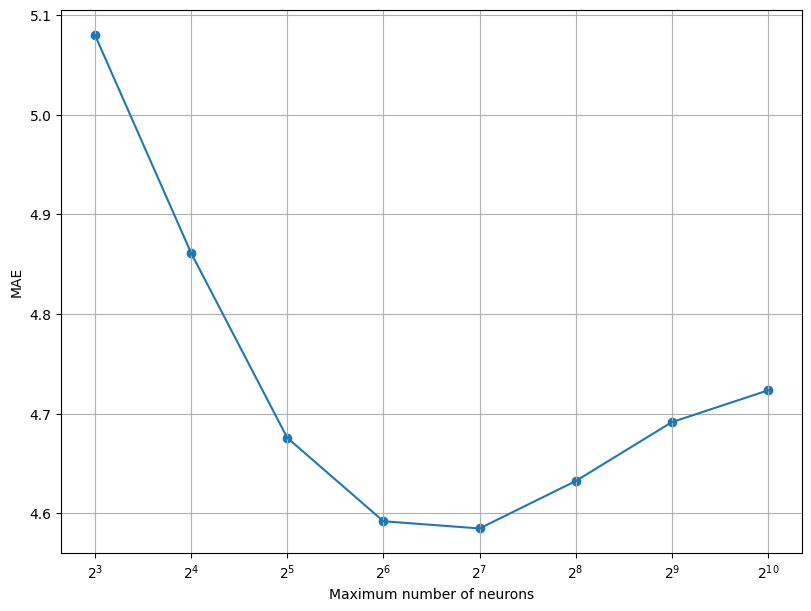

In [29]:
cv16f_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, neurons, target="neurons", metric="mae", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16f_neurons_avg_results, "Maximum number of neurons", log=True)

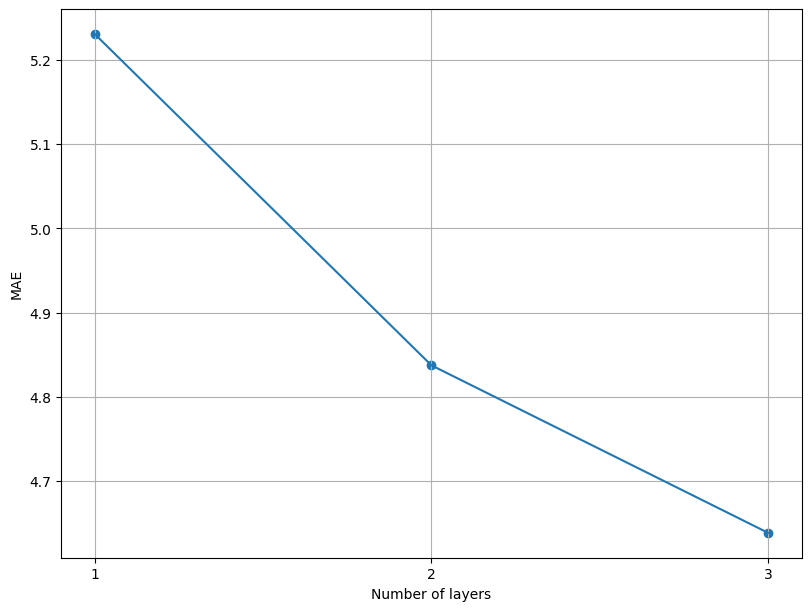

In [30]:
cv16f_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16f_layers_avg_results, "Number of layers", log=False, intx=True)

In [31]:
cv16f_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"Con OSNR  Sin OSNR")
print(f"{cv16f_osnr_avg_results[0]:.3f}       {cv16f_osnr_avg_results[1]:.3f}")

Con OSNR  Sin OSNR
4.232       5.228


In [32]:
cv16f_better_models_df = get_better_models(
    cv16f_reg_results, metric="mae", score="test"
)
cv16f_better_models_df.head(10)

column_0,column_1
f64,list[str]
2.756541,"[""tst"", ""128"", ""osnr""]"
2.822385,"[""tst"", ""64"", ""osnr""]"
2.830602,"[""rtt"", ""64"", ""osnr""]"
2.837135,"[""tss"", ""64"", ""osnr""]"
2.842542,"[""rss"", ""32"", ""osnr""]"
2.852606,"[""rtt"", ""512"", ""osnr""]"
2.871675,"[""rst"", ""128"", ""osnr""]"
2.873786,"[""tst"", ""512"", ""osnr""]"
2.886047,"[""rrs"", ""256"", ""osnr""]"


## GKM

### Load data

In [5]:
if GOOGLE_COLAB:
    cv16g_file = "counting_vectors_16g.csv"
else:
    cv16g_file = "../../Databases/16GBd/counting_vectors_16g.csv"

cv16g = pl.read_csv(cv16g_file, has_header=False, dtypes=[pl.Float64])
# Show the original dataframe
cv16g

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7955,0.1557,0.0309,0.0145,0.0021,0.0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7988,0.1467,0.034,0.0149,0.0035,0.0015,0.0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.789,0.1601,0.0332,0.0132,0.0032,0.0008,0.0002,0.0002,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7957,0.1542,0.0311,0.0152,0.0024,0.0013,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7947,0.1477,0.0352,0.0143,0.0053,0.0023,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7976,0.152,0.0316,0.0152,0.0031,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7736,0.1619,0.0386,0.0179,0.0039,0.0031,0.0004,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8089,0.1469,0.0293,0.0114,0.0025,0.0009,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8025,0.1523,0.029,0.013,0.0025,0.0005,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [6]:
interval_lst = {"2": [(0, 35), (35, 50)],
                "3": [(0, 32), (32, 35), (35, 50)],
                "4": [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)],
                "5": [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]}

cv16g_class = {}
for classes_n, interval in interval_lst.items():
    cv16g_class[classes_n] = classificator(cv16g, interval, "column_18")
cv16g_class

{'2': shape: (680, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.7955   ┆ 0.1557   ┆ 0.0309   ┆ 0.0145   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.7988   ┆ 0.1467   ┆ 0.034    ┆ 0.0149   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.789    ┆ 0.1601   ┆ 0.0332   ┆ 0.0132   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.7957   ┆ 0.1542   ┆ 0.0311   ┆ 0.0152   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

In [7]:
# Shuffle the dataframe
cv16g_class_shuffled = {}
for classes_n, df in cv16g_class.items():
    cv16g_class_shuffled[classes_n] = df.sample(n=len(df), shuffle=True, seed=1036681523)
cv16g_class_shuffled

{'2': shape: (680, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 0.0       │
 │ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 0.0       │
 │ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

In [8]:
# Extract 10% of the data to use later for "production" testing
cv16g_class_prod = {}
for classes_n, df in cv16g_class_shuffled.items():
    cv16g_class_prod[classes_n] = df[: int(len(df) * 0.1)]
cv16g_class_prod

{'2': shape: (68, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.8907   ┆ 0.0905   ┆ 0.0119   ┆ 0.0054   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 0.0       │
 │ 0.8867   ┆ 0.0966   ┆ 0.0117   ┆ 0.0047   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 0.0       │
 │ 0.8751   ┆ 0.108    ┆ 0.0134   ┆ 0.0033   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 0.0       │
 │ 0.9991   ┆ 0.0009   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ 

In [9]:
# Use the rest of the data for normal testing
cv16g_class_new = {}
for classes_n, df in cv16g_class_shuffled.items():
    cv16g_class_new[classes_n] = df[int(len(df) * 0.1) :]
cv16g_class_new

{'2': shape: (612, 18)
 ┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0.9999   ┆ 0.0001   ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 26.3      ┆ 1.0       │
 │ 0.9975   ┆ 0.0024   ┆ 0.0      ┆ 0.0001   ┆ … ┆ 0.0       ┆ 0.0       ┆ 26.3      ┆ 0.0       │
 │ 0.9802   ┆ 0.0193   ┆ 0.0003   ┆ 0.0002   ┆ … ┆ 0.0       ┆ 0.0       ┆ 19.3      ┆ 0.0       │
 │ 0.977    ┆ 0.0214   ┆ 0.0011   ┆ 0.0005   ┆ … ┆ 0.0       ┆ 0.0       ┆ 23.3      ┆ 0.0       │
 │ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆

### Hyperparameters evaluation

In [ ]:
try:
    cv16g_class_results = sofa.load_hdf5(f"{ROOT}/cv16g_class_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16g_class_results = defaultdict(
        defaultdict(defaultdict(defaultdict(defaultdict().copy).copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            for n in classes_n:
                args = {
                    "data": cv16g_class_new[n],
                    "data_prod": cv16g_class_prod[n],
                    "n_splits": 5,
                    "classes_n": int(n),
                    "max_neurons": int(neurons),
                    "activations": activations,
                    "use_osnr": True if osnr == "osnr" else False,
                }
                act_fn_name = "".join([s[0] for s in activations])
                if cv16g_class_results[act_fn_name][neurons][osnr][n] == defaultdict():
                    # Get results
                    results = test_classification_model(**args)
                    # Serialize model
                    results["model"] = [
                        utils.serialize_keras_object(model) for model in results["model"]
                    ]
                    # Save serialized model for serialization
                    cv16g_class_results[act_fn_name][neurons][osnr][n] = results
                    # Save results with serialized model
                    print("Saving results...")
                    sofa.save_hdf5(cv16g_class_results, f"{ROOT}/cv16g_class_results.h5", n_backups = 5)
                    print("Results saved!")

### Results

In [ ]:
cv16g_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_class_results, neurons, target="neurons", metric="acc", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16g_neurons_avg_results, "Maximum number of neurons", log=True)

In [ ]:
cv16g_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_class_results, layers, target="layers", metric="acc", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16g_layers_avg_results, "Number of layers", log=False, intx=True)

In [ ]:
cv16g_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_class_results, osnr, target="osnr", metric="acc", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"With OSNR  Without OSNR")
print(f"{cv16g_osnr_avg_results[0]:.3f}       {cv16g_osnr_avg_results[1]:.3f}")

In [ ]:
cv16g_classes_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_class_results, classes, target="classes", metric="acc", score="test"
        )
    )
    for classes in n_classes
]
x = n_classes
plot_results(x, cv16g_classes_avg_results, "Number of classes", log=False, intx=True)

### Sort models by score

In [ ]:
cv16g_better_models_df = get_better_models(
    cv16g_class_results, metric="acc", score="test"
)
cv16g_better_models_df.head(10)

In [28]:
try:
    cv16g_reg_results = sofa.load_hdf5(f"{ROOT}/cv16g_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16g_reg_results = defaultdict(
        defaultdict(defaultdict(defaultdict().copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {
                "data": cv16g_new,
                "data_prod": cv16g_prod,
                "n_splits": 5,
                "max_neurons": int(neurons),
                "activations": activations,
                "use_osnr": True if osnr == "osnr" else False,
            }
            act_fn_name = "".join([s[0] for s in activations])
            if cv16g_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [
                    utils.serialize_keras_object(model) for model in results["model"]
                ]
                # Save serialized model for serialization
                cv16g_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(cv16g_reg_results, f"{ROOT}/cv16g_reg_results.h5")
                print("Results saved!")

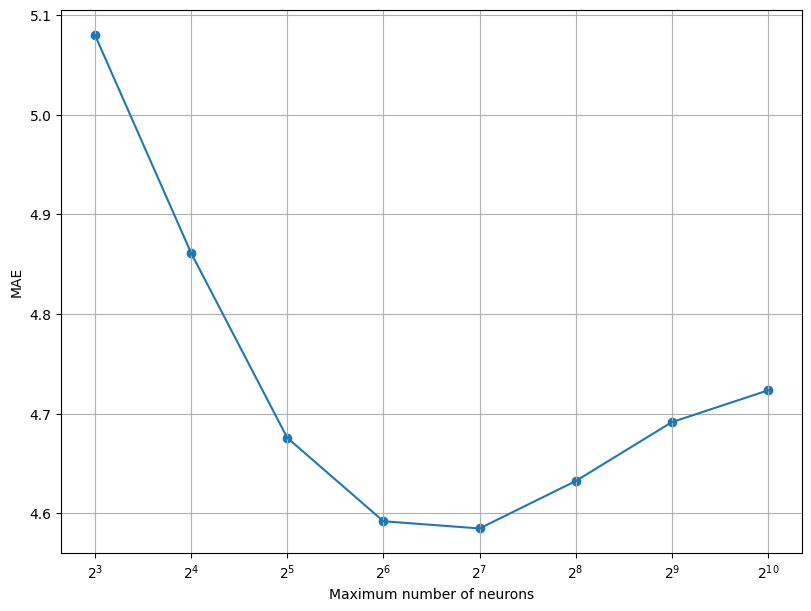

In [29]:
cv16g_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, neurons, target="neurons", metric="mae", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16g_neurons_avg_results, "Maximum number of neurons", log=True)

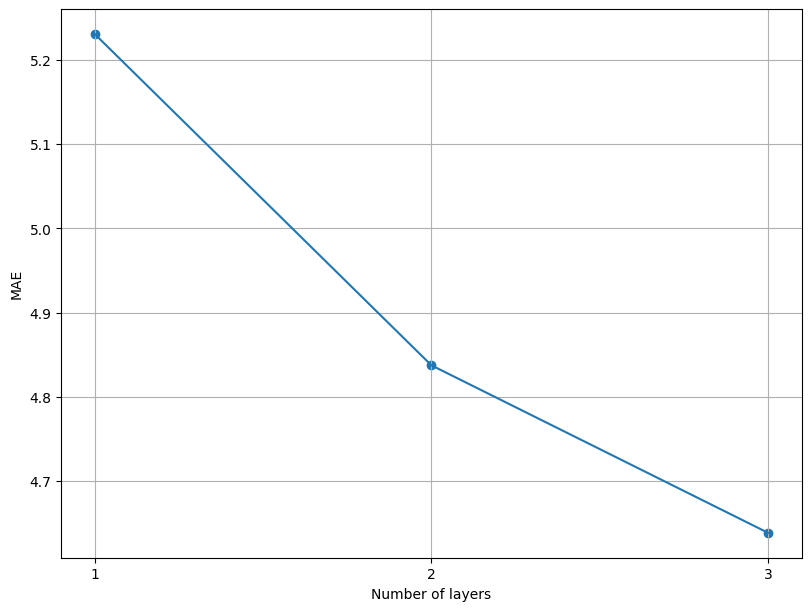

In [30]:
cv16g_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16g_layers_avg_results, "Number of layers", log=False, intx=True)

In [31]:
cv16g_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"Con OSNR  Sin OSNR")
print(f"{cv16g_osnr_avg_results[0]:.3f}       {cv16g_osnr_avg_results[1]:.3f}")

Con OSNR  Sin OSNR
4.232       5.228


In [32]:
cv16g_better_models_df = get_better_models(
    cv16g_reg_results, metric="mae", score="test"
)
cv16g_better_models_df.head(10)

column_0,column_1
f64,list[str]
2.756541,"[""tst"", ""128"", ""osnr""]"
2.822385,"[""tst"", ""64"", ""osnr""]"
2.830602,"[""rtt"", ""64"", ""osnr""]"
2.837135,"[""tss"", ""64"", ""osnr""]"
2.842542,"[""rss"", ""32"", ""osnr""]"
2.852606,"[""rtt"", ""512"", ""osnr""]"
2.871675,"[""rst"", ""128"", ""osnr""]"
2.873786,"[""tst"", ""512"", ""osnr""]"
2.886047,"[""rrs"", ""256"", ""osnr""]"
